In [11]:
import numpy as np
import os
import shutil
import random
import cv2
import PIL
import PIL.Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import *
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization

Visualizing first image from each folder:


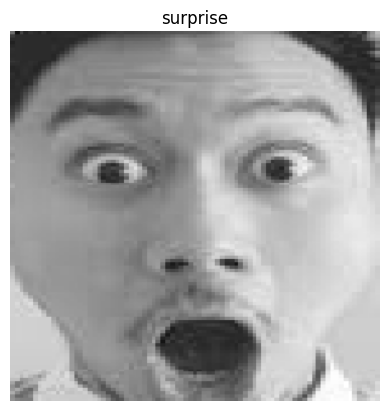

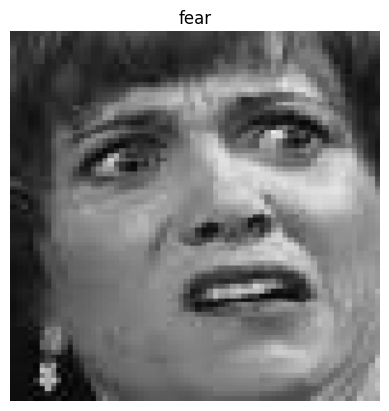

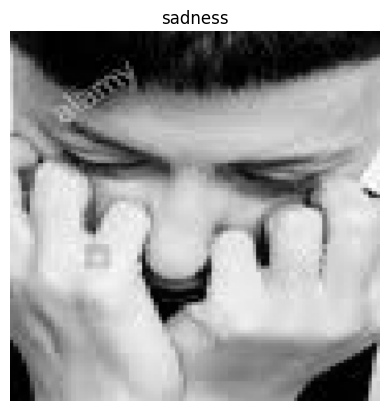

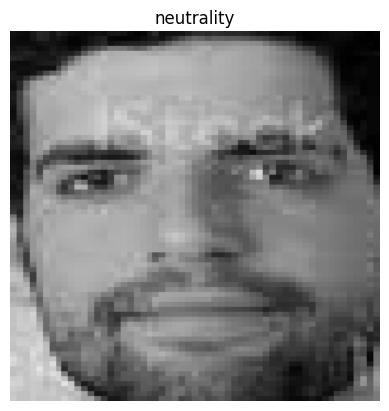

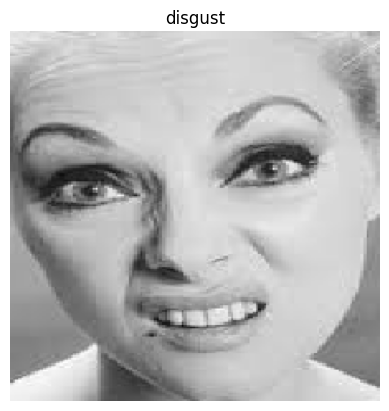

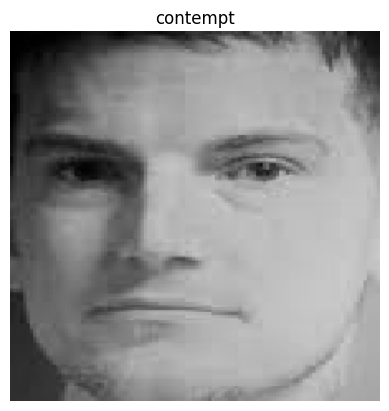

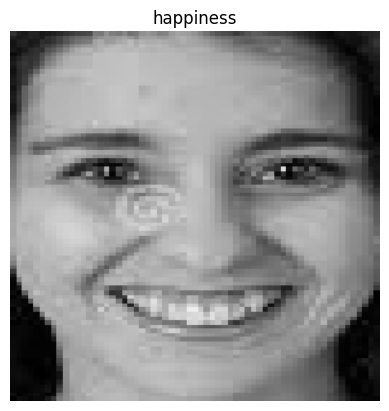

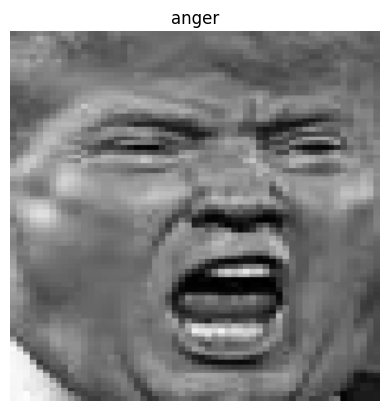

In [3]:
data_folder=r'/kaggle/input/random-images-for-face-emotion-recognition'
def visualize_first_image(folder):
    for image_class in os.listdir(folder):
        class_folder = os.path.join(folder, image_class)
        if os.path.isdir(class_folder):
            image_files = os.listdir(class_folder)
            if image_files:
                image_path = os.path.join(class_folder, image_files[0])
                if os.path.isfile(image_path):
                    img = cv2.imread(image_path)
                    if img is not None:
                        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                        plt.title(image_class)
                        plt.axis('off')
                        plt.show()
                    else:
                        print("Error reading image:", image_path)
                else:
                    print("Not a file:", image_path)
            else:
                print("No images in folder:", class_folder)
        else:
            print("Not a folder:", class_folder)

print("Visualizing first image from each folder:")
visualize_first_image(data_folder)

In [4]:
data=tf.keras.utils.image_dataset_from_directory(data_folder,batch_size=8)
print(data)

Found 5558 files belonging to 8 classes.
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [5]:
data_iterator=data.as_numpy_iterator()
data_iterator

In [6]:
batch=data_iterator.next()
print(batch[0].shape)
print(batch[1])

(8, 256, 256, 3)
[7 5 2 2 1 5 7 2]


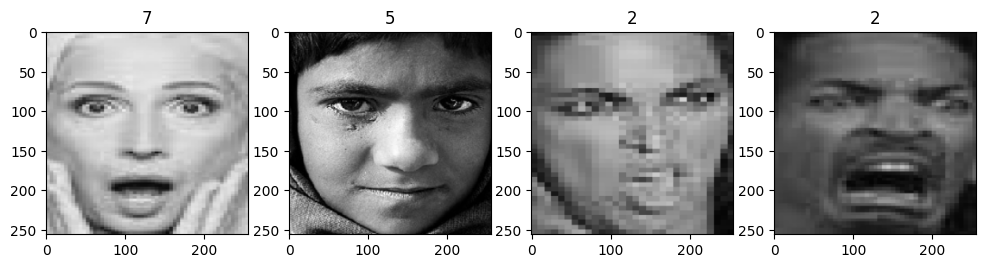

In [8]:
#Class 0: Anger
#Class 1: Contempt
#Class 2: Disgust
#Class 3: Fear
#Class 4: Happy
#Class 5: Neutral
#Class 6: Sad
#Class 7: Surprise
fig,ax=plt.subplots(ncols=4,figsize=(12,6))
for idx,img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [9]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
batch_size = 8
target_size = (256, 256) 
class_mode = 'categorical'

In [12]:
train_folder = '/kaggle/working/train'
val_folder = '/kaggle/working/val'
os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)
class_folders = ['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutrality', 'sadness', 'surprise']
train_split = 0.8
for class_folder in class_folders:
    class_path = os.path.join(data_folder, class_folder)   
    image_files = os.listdir(class_path)
    random.shuffle(image_files)
    split_index = int(len(image_files) * train_split)
    train_files = image_files[:split_index]
    val_files = image_files[split_index:]
    
    train_class_folder = os.path.join(train_folder, class_folder)
    val_class_folder = os.path.join(val_folder, class_folder)
    os.makedirs(train_class_folder, exist_ok=True)
    os.makedirs(val_class_folder, exist_ok=True)
for train_file in train_files:
    src_train = os.path.join(class_path, train_file)
    dst_train = os.path.join(train_class_folder, train_file)
    shutil.copy(src_train, dst_train)

for val_file in val_files:
    src_val = os.path.join(class_path, val_file)
    dst_val = os.path.join(val_class_folder, val_file)
    shutil.copy(src_val, dst_val)

In [16]:
train_generator = train_datagen.flow_from_directory(
    directory=train_folder,
    target_size=target_size,
    batch_size=batch_size,
    class_mode=class_mode,
    shuffle=True,
    color_mode='grayscale',
    subset=None
)
validation_generator = val_datagen.flow_from_directory(
    directory=val_folder,
    target_size=target_size,
    batch_size=batch_size,
    class_mode=class_mode,
    shuffle=True,
    color_mode='grayscale',
    subset=None
)

Found 620 images belonging to 8 classes.
Found 155 images belonging to 8 classes.


In [21]:
CNN_model = Sequential([
    Conv2D(64, (3, 3), padding='same', input_shape=(256, 256, 1)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    # 2nd CNN layer
    Conv2D(128, (5, 5), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Conv2D(512, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    # 4th CNN layer
    Conv2D(512, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Flatten(),
    
    # Fully connected 1st layer
    Dense(256),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),
    
    # Fully connected layer 2nd layer
    Dense(512),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),
    
    Dense(8, activation='softmax')

])

In [22]:
CNN_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
CNN_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 256, 256, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 128)  │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 64, 64, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 64, 64, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 32, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 32, 32, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 32, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │    33,554,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 256)            │         1,02

 Total params: 36,854,024 (140.59 MB)

 Trainable params: 36,850,056 (140.57 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [24]:
history = CNN_model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-05-12 19:33:07.999030: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.58222, expected 0.737369
2024-05-12 19:33:07.999086: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.41128, expected 1.56643
2024-05-12 19:33:07.999095: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.76015, expected 1.91529
2024-05-12 19:33:07.999103: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.49696, expected 1.65211
2024-05-12 19:33:07.999111: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1

 3/78 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.3403 - loss: 2.4213 

I0000 00:00:1715542400.597765     145 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715542400.624141     145 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/78 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.4839 - loss: 1.7633

2024-05-12 19:33:25.553636: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65536: 0.961309, expected 0.421057
2024-05-12 19:33:25.553706: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65537: 2.31528, expected 1.77503
2024-05-12 19:33:25.553716: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65538: 2.17812, expected 1.63786
2024-05-12 19:33:25.553724: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65539: 2.11732, expected 1.57707
2024-05-12 19:33:25.553732: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65540: 2.64766, expected 2.1074
2024-05-12 19:33:25.553740: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65541: 2.68691, expected 2.14665
2024-05-12 19:33:25.553748: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65542: 2.00241, expected 1.46216
2024-05-12 19:33:25.553755

15/78 ━━━━━━━━━━━━━━━━━━━━ 1:06 1s/step - accuracy: 0.5492 - loss: 1.5525

W0000 00:00:1715542415.325373     148 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.8393 - loss: 0.5793

W0000 00:00:1715542419.608433     146 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024-05-12 19:33:40.118199: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 0.727908, expected 0.233536
2024-05-12 19:33:40.118259: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 1.7588, expected 1.26443
2024-05-12 19:33:40.118275: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 1.59598, expected 1.10161
2024-05-12 19:33:40.118293: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.28727, expected 1.7929
2024-05-12 19:33:40.118307: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.27906, expected 1.78469
2024-05-12 19:33:40.118318: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 1.91854, expected 1.42417
2024-05-12 19:33:40.118329: E external/local_xla/xla/service/gpu/

78/78 ━━━━━━━━━━━━━━━━━━━━ 43s 273ms/step - accuracy: 0.8408 - loss: 0.5742 - val_accuracy: 1.0000 - val_loss: 0.0080
Epoch 2/20
 2/78 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 1.0000 - loss: 0.0016 

W0000 00:00:1715542421.647811     148 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 1.0000 - val_loss: 0.0018
Epoch 3/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 1.0000 - val_loss: 8.8793e-04
Epoch 4/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 3.9222e-04
Epoch 5/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 1.0000 - loss: 9.3865e-04 - val_accuracy: 1.0000 - val_loss: 2.4390e-04
Epoch 6/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 1.0000 - loss: 7.9783e-04 - val_accuracy: 1.0000 - val_loss: 2.3934e-04
Epoch 7/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 1.0000 - loss: 4.6662e-04 - val_accuracy: 1.0000 - val_loss: 3.5474e-04
Epoch 8/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 1.0000 - loss: 3.8806e-04 - val_accuracy: 1.0000 - val_loss: 3.9406e-04
Epoch 9/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 1.0000 - loss: 3.32

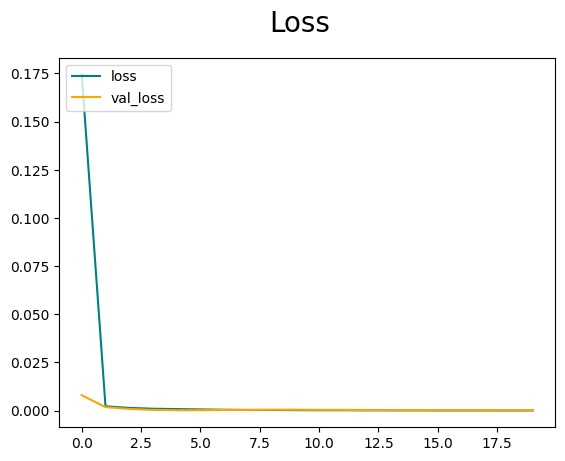

In [25]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

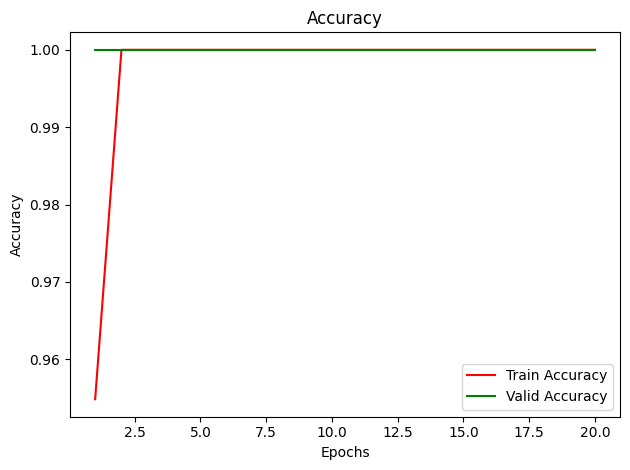

In [26]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = [i+1 for i in range(len(tr_acc))]


plt.plot(epochs, tr_acc, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc, 'g', label='Valid Accuracy')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()